In [5]:
import numpy as np


In [283]:
def probability(epsilon, d, q =2):
    return np.exp(epsilon*q)/ (np.exp(epsilon) - 1 + d)
def q(x_, x, d):
    if np.sum(x == x_) == d :
        return 1
    else:
        return 0
    
def Rand(xs_in, d, epsilon):
    i = np.random.randint(d)
    x = np.eye(d)[i]
    probs = [probability(epsilon, d, q(x_, x, d)) for x_ in xs_in]
    xs_out = []
    for j in range(len(xs_in)):
        if np.random.random() < probs[j]:
            xs_out.append(xs_in[j])
        else: 
            t = np.random.randint(d)
            xs_out.append(np.eye(d)[t])
    return xs_out

def beta(epsilon, r, c):
    return 1/(np.exp(epsilon) + r*c - 1)

def p_hat(pi_1, pi_2, epsilon):
    r = len(pi_1)
    c = len(pi_2)

    return beta(epsilon, r, c)*((np.exp(epsilon) - 1)* pi_1.T @ pi_2 + 1) 

def new_pis(pi_1, pi_2, r, c, n, epsilon):
    betta = beta(epsilon, r, c)
    pi_1_new = 1/betta/(np.exp(epsilon) - 1)*(pi_1/n - c*betta) 
    pi_2_new = 1/betta/(np.exp(epsilon) - 1)*(pi_2/n - r*betta)
#     print(pi_1_new, pi_2_new)
    
    return np.array(pi_1_new), np.array(pi_2_new)

def tau(obs_1, obs_2, r, c, n, epsilon):

    H_obs = obs_1.T@ obs_2
    pi_1 = np.sum(obs_1, axis =0).reshape((1, -1))
    pi_2 = np.sum(obs_2, axis =0).reshape((1, -1))
    pi_1_new, pi_2_new = new_pis(pi_1, pi_2, r, c, n, epsilon)
#     print(pi_1_new)
    p_hats_new = beta(epsilon, r, c)*((np.exp(epsilon) - 1)* pi_1_new.T @ pi_2_new + 1) #p_hat(pi_1_new, pi_2_new, epsilon)
#     print(p_hats_new)
#     print(np.sum(p_hats_new))

    return np.sum((H_obs - p_hats_new*n)**2/n/p_hats_new)

def LocalGenRRIND(x, y, r, c, epsilon,n, alpha):
    x_rand = np.array(Rand(x, r, epsilon))
    y_rand = np.array(Rand(y, c, epsilon))
    test = tau(x_rand, y_rand, r, c, n, epsilon)
    tre = chi2.ppf(1 - alpha, (r-1)*(c-1))
    # print(test)
    if test < tre:
        return True
    else:
        return False 

In [284]:
def calculate_power_rand(pi_1, pi_2, epsilon, n, trials, r, c, alp):
    rej = 0 
    for i in range(trials):
        first = np.array([1 if i % 2 == 0 else -1 for i in range(r)]).reshape((-1,1))
        second = np.array([1 if i % 2 == 0 else -1 for i in range(c)]).reshape((-1,1))
        nu = 0.01
        pi_1_ = pi_1.reshape(-1,1) + nu*first
        pi_2_ = pi_2.reshape(-1,1) + nu*second
        # print(pi_2_)
        obs_1 = np.random.multinomial(1, pi_1_.T[0], size=n).reshape((-1, r))
        obs_2 = np.random.multinomial(1, pi_2_.T[0], size=n).reshape((-1, c ))
        if not LocalGenRRIND(obs_1, obs_2, r, c, epsilon, n, alp):
            rej +=1
    # print(rej)
    return rej/trials

In [301]:
from scipy.stats import chi2
r = 4
c = 2
n = 1000
trials = 50
eps = [4, 5, 6]
ns = [(i)*300 for i in range(1, 30, 5)]
alp = 0.05
pi_1 = np.array([1/r]*r)
pi_2 = np.array([1/c]*c)


8400

In [308]:
import multiprocessing as mp
trials=50
pool = mp.Pool(4)
epsilon = 4

alp = 0.05

results_nu_1 = [pool.apply(calculate_power_rand, args=(pi_1, pi_2, epsilon, int(n), trials, r, c, alp)) for n in ns]

pool.close()    
pool = mp.Pool(4)
epsilon = 5

results_nu_2 = [pool.apply(calculate_power_rand, args=(pi_1, pi_2, epsilon, int(n), trials, r, c, alp)) for n in ns]

pool.close()  
pool = mp.Pool(4)
epsilon = 6

results_nu_4 = [pool.apply(calculate_power_rand, args=(pi_1, pi_2, epsilon, int(n), trials, r, c, alp)) for n in ns]

pool.close()  

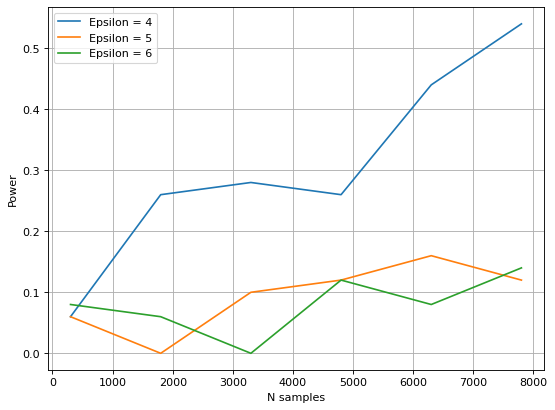

In [310]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.plot(ns, np.array(results_nu_1), label=f'Epsilon = {eps[0]}')

plt.plot(ns, np.array(results_nu_2), label=f'Epsilon = {eps[1]}')

plt.plot(ns, np.array(results_nu_4), label=f'Epsilon = {eps[2]}')
plt.legend()
#plt.xlim(0,3000)
plt.xlabel('N samples')
plt.ylabel('Power')
plt.grid(True)
plt.savefig('Rand.png')